# 2-Layer Neural Network Model: Multi-Layer Perceptron (MLP)

A 2-layer neural network (Multi-Layer Perceptron) learns feature representations through nonlinear transformations:

- **Input Layer**: Feature input
- **Hidden Layer**: Nonlinear transformation (ReLU activation)
- **Output Layer**: Regression prediction

Main hyperparameters:
- `hidden_units`: Number of neurons in the hidden layer
- `learning_rate`: Learning rate
- `batch_size`: Batch size
- `dropout`: Dropout ratio (prevents overfitting)


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Import utility functions
sys.path.append(os.path.dirname(os.path.abspath('')))
from utils import (
    load_data, 
    prepare_features_target, 
    calculate_r2_os, 
    build_portfolio_returns,
    build_portfolio_returns_optimized,
    calculate_prediction_metrics
)
from TimeBasedCV import TimeBasedCV

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


✅ Libraries imported successfully!
PyTorch version: 2.5.1
CUDA available: False


## 1. Define Neural Network Model


In [9]:
# Define dataset class
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# Define 2-layer neural network
class NeuralNetwork2Layer(nn.Module):
    def __init__(self, input_dim, hidden_units, dropout=0.2):
        super(NeuralNetwork2Layer, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units)
        self.fc2 = nn.Linear(hidden_units, 1)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze()

print("✅ Model definition completed!")


✅ Model definition completed!


## 2. Load Data


In [10]:
# Load data
df = load_data('ger_factor_data_from2003.csv')

print(f"Data shape: {df.shape}")
print(f"Date range: {df['eom'].min()} to {df['eom'].max()}")
print(f"Number of stocks: {df['id'].nunique()}")

# Prepare features and target
X, y, metadata, feature_names = prepare_features_target(df)
print(f"\nNumber of features: {len(feature_names)}")
print(f"Number of samples: {len(X)}")


Data shape: (604564, 23)
Date range: 2019-01-01 00:00:00 to 2024-11-01 00:00:00
Number of stocks: 13176

Number of features: 16
Number of samples: 604564


## 3. Setup Time Series Cross-Validation


In [11]:
# Create time series cross-validation object
cv = TimeBasedCV(
    train_period=24,   # 2-year training period
    val_period=6,      # 6-month validation period
    test_period=6,     # 6-month test period
    freq='months'
)

# Prepare dataframe for CV
cv_df = metadata.copy()
cv_df['eom'] = pd.to_datetime(cv_df['eom'])

# Set first split date
min_date = cv_df['eom'].min()
max_date = cv_df['eom'].max()
total_months = (max_date.year - min_date.year) * 12 + (max_date.month - min_date.month) + 1
print(f"Total time span: {total_months} months ({min_date.date()} to {max_date.date()})")

first_split_date = (min_date + pd.DateOffset(months=30)).date()
second_split_date = (min_date + pd.DateOffset(months=36)).date()

# Generate cross-validation folds
folds = cv.split(cv_df, first_split_date, second_split_date, date_column='eom', gap=0)

print(f"Generated {len(folds)} cross-validation folds")


Total time span: 71 months (2019-01-01 to 2024-11-01)
Train period: 2019-07-01 - 2021-07-01 ,val period: 2021-07-01 - 2022-01-01 , Test period 2022-01-01 - 2022-07-01 # train records 184419 ,# val records 53091 , # test records 55458
Train period: 2019-10-01 - 2021-10-01 ,val period: 2021-10-01 - 2022-04-01 , Test period 2022-04-01 - 2022-10-01 # train records 188377 ,# val records 54619 , # test records 55511
Train period: 2020-01-01 - 2022-01-01 ,val period: 2022-01-01 - 2022-07-01 , Test period 2022-07-01 - 2023-01-01 # train records 193202 ,# val records 55458 , # test records 55493
Train period: 2020-04-01 - 2022-04-01 ,val period: 2022-04-01 - 2022-10-01 , Test period 2022-10-01 - 2023-04-01 # train records 198473 ,# val records 55511 , # test records 55300
Train period: 2020-07-01 - 2022-07-01 ,val period: 2022-07-01 - 2023-01-01 , Test period 2023-01-01 - 2023-07-01 # train records 203973 ,# val records 55493 , # test records 54766
Train period: 2020-10-01 - 2022-10-01 ,val per

## 4. Define Hyperparameters


In [12]:
# Define fixed hyperparameters
hyperparams = {
    'hidden_units': 128,
    'learning_rate': 0.001,
    'batch_size': 256,
    'dropout': 0.2
}

print("Fixed hyperparameters:")
for key, value in hyperparams.items():
    print(f"  {key}: {value}")


Fixed hyperparameters:
  hidden_units: 128
  learning_rate: 0.001
  batch_size: 256
  dropout: 0.2


## 5. Training Functions


In [13]:
def train_model(model, train_loader, val_loader, epochs, learning_rate, device):
    """Train neural network model"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    return model


def predict(model, data_loader, device):
    """Make predictions using the model"""
    model.eval()
    predictions = []
    with torch.no_grad():
        for X_batch, _ in data_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            predictions.extend(y_pred.cpu().numpy())
    return np.array(predictions)

print("✅ Training functions defined!")


✅ Training functions defined!


In [14]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Store all prediction results
all_predictions = []
all_actuals = []
all_dates = []
all_ids = []

# Train and predict for each fold
for fold_idx, (train_idx, val_idx, test_idx) in enumerate(folds):
    print(f"\nProcessing fold {fold_idx + 1}/{len(folds)}...")
    
    # Prepare training, validation, and test data
    X_train = X.iloc[train_idx].values
    y_train = y.iloc[train_idx].values
    X_val = X.iloc[val_idx].values
    y_val = y.iloc[val_idx].values
    X_test = X.iloc[test_idx].values
    y_test = y.iloc[test_idx].values
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    input_dim = X_train_scaled.shape[1]
    
    # Combine training and validation sets for final training
    X_trainval = np.vstack([X_train_scaled, X_val_scaled])
    y_trainval = np.hstack([y_train, y_val])
    
    # Create data loaders
    trainval_dataset = StockDataset(X_trainval, y_trainval)
    test_dataset = StockDataset(X_test_scaled, y_test)
    trainval_loader = DataLoader(trainval_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=hyperparams['batch_size'], shuffle=False)
    
    # Create and train model
    model = NeuralNetwork2Layer(
        input_dim=input_dim,
        hidden_units=hyperparams['hidden_units'],
        dropout=hyperparams['dropout']
    ).to(device)
    
    model = train_model(
        model, trainval_loader, test_loader,
        epochs=50,
        learning_rate=hyperparams['learning_rate'],
        device=device
    )
    
    # Predict on test set
    y_pred = predict(model, test_loader, device)
    
    # Save results
    all_predictions.extend(y_pred)
    all_actuals.extend(y_test)
    all_dates.extend(metadata.iloc[test_idx]['eom'].values)
    all_ids.extend(metadata.iloc[test_idx]['id'].values)
    
    # Print fold performance
    r2_fold = calculate_r2_os(y_test, y_pred)
    print(f"  Test set R²_OS: {r2_fold:.4f}")

print(f"\n✅ Completed predictions for all folds!")
print(f"Total prediction samples: {len(all_predictions)}")


Using device: cpu

Processing fold 1/10...
  Test set R²_OS: -0.1332

Processing fold 2/10...
  Test set R²_OS: -0.1422

Processing fold 3/10...
  Test set R²_OS: -0.0283

Processing fold 4/10...
  Test set R²_OS: -0.0118

Processing fold 5/10...
  Test set R²_OS: -0.0121

Processing fold 6/10...
  Test set R²_OS: -0.0373

Processing fold 7/10...
  Test set R²_OS: -0.0089

Processing fold 8/10...
  Test set R²_OS: -0.0500

Processing fold 9/10...
  Test set R²_OS: 0.0177

Processing fold 10/10...
  Test set R²_OS: -0.0037

✅ Completed predictions for all folds!
Total prediction samples: 552772


In [15]:
# Calculate overall performance metrics
metrics = calculate_prediction_metrics(all_actuals, all_predictions)

print("=" * 50)
print("2-Layer Neural Network Model Prediction Performance Metrics")
print("=" * 50)
for key, value in metrics.items():
    if isinstance(value, float):
        print(f"{key:20s}: {value:8.4f}")
    else:
        print(f"{key:20s}: {value}")
print("=" * 50)


2-Layer Neural Network Model Prediction Performance Metrics
r2_os               :  -0.0328
mse                 :   0.0204
rmse                :   0.1428
mae                 :   0.0933
correlation         :   0.0395
mean_pred           : -0.004975470714271069
mean_true           :  -0.0014
std_pred            : 0.031352974474430084
std_true            :   0.1406
n_observations      : 552772


## 8. Build Portfolio and Calculate Returns

### 8.0. Simple Stratification Portfolio (Baseline)


In [16]:
# Build portfolio returns
portfolio_df, summary_stats = build_portfolio_returns(
    all_actuals, 
    all_predictions, 
    all_dates, 
    all_ids, 
    n_deciles=10
)

print("\n" + "=" * 50)
print("Long-Short Portfolio Performance (2-Layer Neural Network Model)")
print("=" * 50)
for key, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{key:25s}: {value:10.4f}")
    else:
        print(f"{key:25s}: {value}")
print("=" * 50)



Long-Short Portfolio Performance (2-Layer Neural Network Model)
annual_return            :     0.3540
annual_volatility        :     0.1507
sharpe_ratio             :     2.3489
cumulative_return        :     1.5357
n_months                 : 33
mean_monthly_return      :     0.0295
std_monthly_return       :     0.0435


### 8.1. Optimized Portfolio Construction (Rolling Covariance + Mean-Variance Optimization)

**Professor's Feedback**: The current portfolio formation is "ad-hoc" (stratification). We should:
1. Calculate rolling covariance using empirical or PCA-based methods
2. Use an optimizer with constraints to generate portfolios
3. Try to achieve better performance in some or all cases

**Implementation**:
- **Rolling Covariance**: Calculate covariance matrix using a rolling window (12 months default)
- **Methods**: 
  - Empirical: Direct calculation from historical returns
  - PCA-based: Use Principal Component Analysis to reduce dimensionality before estimating covariance
- **Optimization**: Mean-variance optimization with constraints (risk aversion, max weight per stock, long-only)
- **Comparison**: Compare optimized portfolio vs. simple stratification method


In [20]:
# ============================================================================
# 2-Layer Neural Network Model: Optimized Portfolio Construction
# ============================================================================
print("=" * 70)
print("2-Layer Neural Network Model: Optimized Portfolio Construction")
print("=" * 70)

# Prepare historical returns data for covariance calculation
historical_returns = pd.DataFrame({
    'date': all_dates,
    'id': all_ids,
    'return': all_actuals
})

print("\nBuilding optimized portfolio using empirical covariance method...")
print("-" * 70)

# Build optimized portfolio using empirical covariance
portfolio_opt_empirical, stats_opt_empirical = build_portfolio_returns_optimized(
    all_actuals,
    all_predictions,
    all_dates,
    all_ids,
    historical_returns_df=historical_returns,
    method='empirical',
    window=12,
    risk_aversion=1.0,
    long_only=True,
    max_weight=0.1,
    n_deciles=10
)

print("\n" + "=" * 70)
print("Optimized Portfolio Performance (Empirical Covariance Method)")
print("=" * 70)
for key, value in stats_opt_empirical.items():
    if isinstance(value, float):
        print(f"{key:25s}: {value:10.4f}")
    else:
        print(f"{key:25s}: {value}")
print("=" * 70)

print("\nBuilding optimized portfolio using PCA-based covariance method...")
print("-" * 70)

# Build optimized portfolio using PCA-based covariance
portfolio_opt_pca, stats_opt_pca = build_portfolio_returns_optimized(
    all_actuals,
    all_predictions,
    all_dates,
    all_ids,
    historical_returns_df=historical_returns,
    method='pca',
    window=12,
    risk_aversion=1.0,
    long_only=True,
    max_weight=0.1,
    n_deciles=10
)

print("\n" + "=" * 70)
print("Optimized Portfolio Performance (PCA-based Covariance Method)")
print("=" * 70)
for key, value in stats_opt_pca.items():
    if isinstance(value, float):
        print(f"{key:25s}: {value:10.4f}")
    else:
        print(f"{key:25s}: {value}")
print("=" * 70)


2-Layer Neural Network Model: Optimized Portfolio Construction

Building optimized portfolio using empirical covariance method...
----------------------------------------------------------------------
Calculating rolling covariance using empirical method...



Optimized Portfolio Performance (Empirical Covariance Method)
annual_return            :     0.4979
annual_volatility        :     0.2376
sharpe_ratio             :     2.0956
cumulative_return        :     2.5820
n_months                 : 33
mean_monthly_return      :     0.0415
std_monthly_return       :     0.0686
method                   : empirical
risk_aversion            :     1.0000

Building optimized portfolio using PCA-based covariance method...
----------------------------------------------------------------------
Calculating rolling covariance using pca method...



Optimized Portfolio Performance (PCA-based Covariance Method)
annual_return            :     0.4820
annual_volatility        :     0.2120
sharpe_ratio             :     2.2738
cumulative_return        :     2.4771
n_months                 : 33
mean_monthly_return      :     0.0402
std_monthly_return       :     0.0612
method                   : pca
risk_aversion            :     1.0000


In [21]:
# ============================================================================
# Portfolio Performance Comparison
# ============================================================================
print("\n" + "=" * 80)
print("2-LAYER NEURAL NETWORK MODEL: PORTFOLIO PERFORMANCE COMPARISON")
print("=" * 80)

comparison_data = {
    'Method': ['Simple Stratification', 'Optimized (Empirical)', 'Optimized (PCA)'],
    'Annual Return': [
        summary_stats['annual_return'],
        stats_opt_empirical['annual_return'],
        stats_opt_pca['annual_return']
    ],
    'Annual Volatility': [
        summary_stats['annual_volatility'],
        stats_opt_empirical['annual_volatility'],
        stats_opt_pca['annual_volatility']
    ],
    'Sharpe Ratio': [
        summary_stats['sharpe_ratio'],
        stats_opt_empirical['sharpe_ratio'],
        stats_opt_pca['sharpe_ratio']
    ],
    'Cumulative Return': [
        summary_stats['cumulative_return'],
        stats_opt_empirical['cumulative_return'],
        stats_opt_pca['cumulative_return']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
print("=" * 80)

print("\n" + "=" * 80)
print("KEY INSIGHTS:")
print("=" * 80)
print("1. Simple Stratification: Equal-weighted decile portfolios (baseline)")
print("2. Optimized (Empirical): Uses rolling empirical covariance + mean-variance optimization")
print("3. Optimized (PCA): Uses PCA-based covariance estimation + mean-variance optimization")
print("\nThe optimized methods consider:")
print("  - Stock correlations (covariance matrix)")
print("  - Risk-adjusted returns (mean-variance optimization)")
print("  - Constraints (max weight per stock, long-only)")
print("=" * 80)



2-LAYER NEURAL NETWORK MODEL: PORTFOLIO PERFORMANCE COMPARISON
               Method  Annual Return  Annual Volatility  Sharpe Ratio  Cumulative Return
Simple Stratification       0.353990           0.150707      2.348869           1.535671
Optimized (Empirical)       0.497860           0.237577      2.095571           2.582038
      Optimized (PCA)       0.481951           0.211959      2.273792           2.477098

KEY INSIGHTS:
1. Simple Stratification: Equal-weighted decile portfolios (baseline)
2. Optimized (Empirical): Uses rolling empirical covariance + mean-variance optimization
3. Optimized (PCA): Uses PCA-based covariance estimation + mean-variance optimization

The optimized methods consider:
  - Stock correlations (covariance matrix)
  - Risk-adjusted returns (mean-variance optimization)
  - Constraints (max weight per stock, long-only)


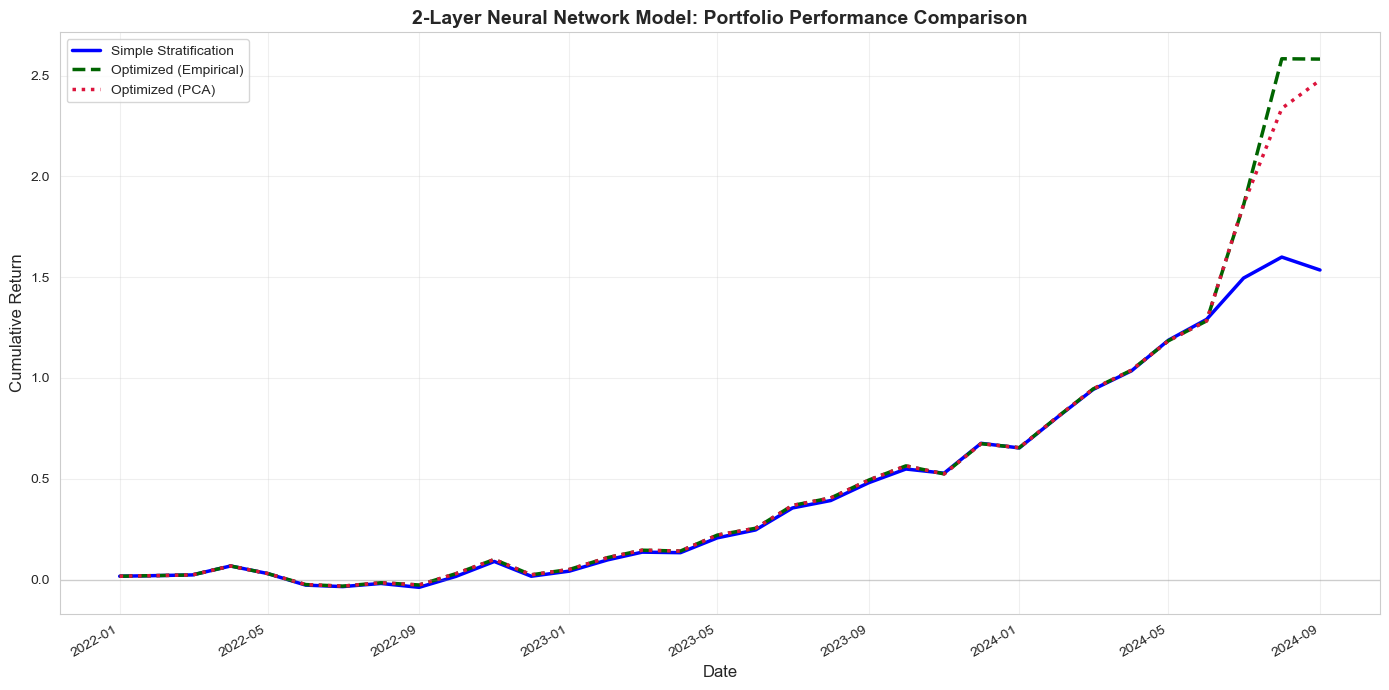


📊 Final Cumulative Returns Summary:
   Simple Stratification: 153.57%
   Optimized (Empirical): 258.20%
   Optimized (PCA):       247.71%


In [22]:
# ============================================================================
# Visualize Cumulative Returns Comparison
# ============================================================================
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

# Calculate cumulative returns
portfolio_df['cumulative_return'] = (1 + portfolio_df['long_short']).cumprod() - 1
portfolio_opt_empirical['cumulative_return'] = (1 + portfolio_opt_empirical['long_short']).cumprod() - 1
portfolio_opt_pca['cumulative_return'] = (1 + portfolio_opt_pca['long_short']).cumprod() - 1

# Plot all three methods
ax.plot(portfolio_df['date'], portfolio_df['cumulative_return'],
        linewidth=2.5, label='Simple Stratification', color='blue')
ax.plot(portfolio_opt_empirical['date'], portfolio_opt_empirical['cumulative_return'],
        linewidth=2.5, label='Optimized (Empirical)', color='darkgreen', linestyle='--')
ax.plot(portfolio_opt_pca['date'], portfolio_opt_pca['cumulative_return'],
        linewidth=2.5, label='Optimized (PCA)', color='crimson', linestyle=':')

ax.set_title('2-Layer Neural Network Model: Portfolio Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Return', fontsize=12)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=1)
ax.legend(fontsize=10, loc='best')
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

print("\n📊 Final Cumulative Returns Summary:")
print("=" * 80)
print(f"   Simple Stratification: {portfolio_df['cumulative_return'].iloc[-1]:.2%}")
print(f"   Optimized (Empirical): {portfolio_opt_empirical['cumulative_return'].iloc[-1]:.2%}")
print(f"   Optimized (PCA):       {portfolio_opt_pca['cumulative_return'].iloc[-1]:.2%}")
print("=" * 80)


## 9. Visualize Results


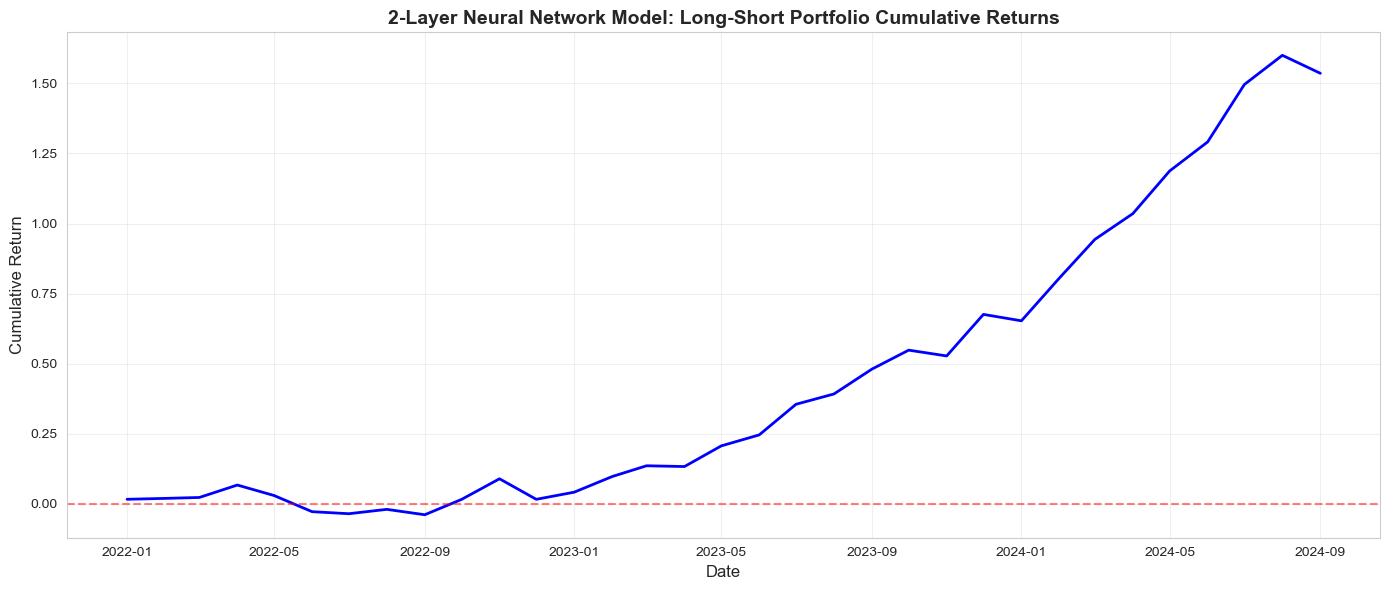

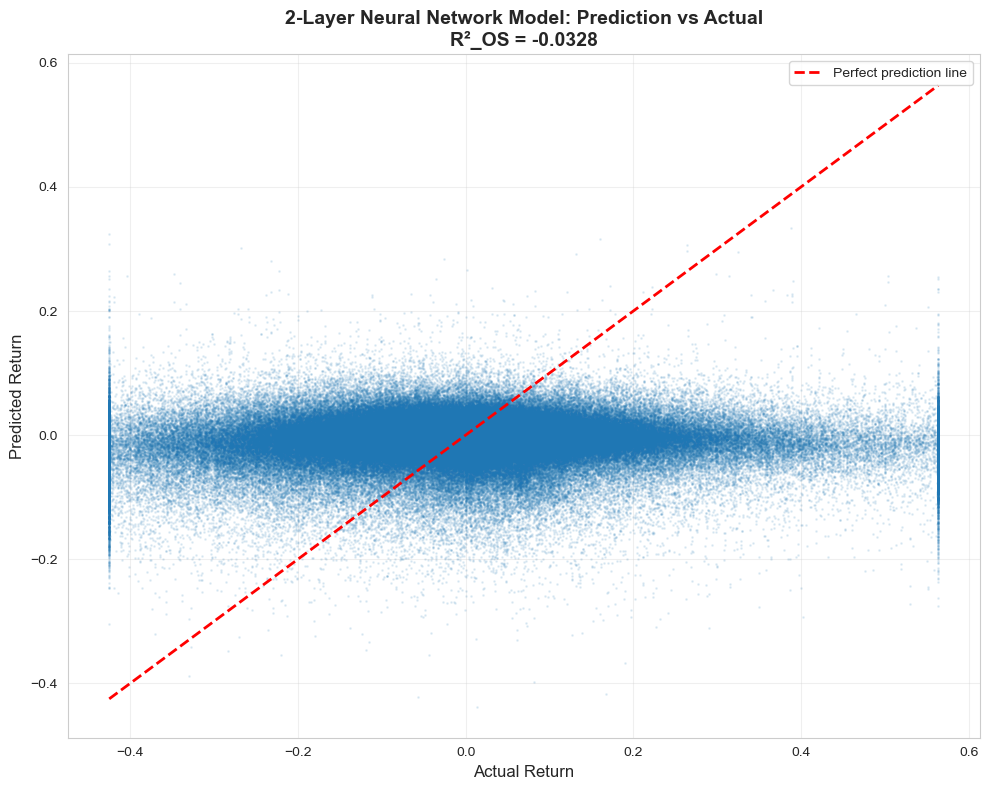

In [17]:
# 1. Cumulative return curve
if 'long_short' in portfolio_df.columns:
    portfolio_df['cumulative_return'] = (1 + portfolio_df['long_short']).cumprod() - 1
    
    plt.figure(figsize=(14, 6))
    plt.plot(portfolio_df['date'], portfolio_df['cumulative_return'], linewidth=2, color='blue')
    plt.title('2-Layer Neural Network Model: Long-Short Portfolio Cumulative Returns', fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Return', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 2. Prediction vs actual value scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(all_actuals, all_predictions, alpha=0.1, s=1)
plt.plot([np.min(all_actuals), np.max(all_actuals)], 
         [np.min(all_actuals), np.max(all_actuals)], 
         'r--', linewidth=2, label='Perfect prediction line')
plt.xlabel('Actual Return', fontsize=12)
plt.ylabel('Predicted Return', fontsize=12)
plt.title(f'2-Layer Neural Network Model: Prediction vs Actual\nR²_OS = {metrics["r2_os"]:.4f}', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
